# 1. Get Data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "food-101-mini"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(image_path / "food-101-mini.zip", "wb") as f:
  request = requests.get("https://github.com/yongbinkim-chemist/deep_learning/raw/refs/heads/main/computer_vision/data/food-101-mini/food-101-mini.zip")
  print("Downloading subset of food-101-mini data...")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(image_path / "food-101-mini.zip", "r") as zip_ref:
  print("Unzipping food-101-mini data...")
  zip_ref.extractall(image_path)

Did not find data/food-101-mini directory, creating one...
Unzipping food-101-mini data...


In [ ]:
!rm -rf data/food-101-mini/__MACOSX/

In [ ]:
import os
os.makedirs("src", exist_ok=True)

# 2. Create DataLoaders

In [ ]:
%%writefile src/data_setup.py
from typing import Tuple, List
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

def create_dataloaders(image_path: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       num_workers: int = 1,
                       seed: int = None) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, List[str]]:
  """Creates training and testing DataLoaders

  Takes in image path and turns it into PyTorch DataLoader.

  Args:
    image_path: Path to images.
    transform: torchvision transforms to perform on images.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
    seed: Random seed for train_test_split.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).

  Example usage:
    train_dataloader, test_dataloader, class_names = create_dataloaders(image_path=path/to/images
                                                                        transform=some_transforms,
                                                                        batch_size=32,
                                                                        num_workers=1,
                                                                        seed=42)
  """

  dataset = datasets.ImageFolder(root=image_path,
                                 transform=transform)
  class_names = dataset.classes

  targets = [label for _, label in dataset.samples]
  indices = list(range(len(targets)))
  train_indices, test_indices = train_test_split(indices,
                                                test_size=0.25,
                                                stratify=targets,
                                                random_state=seed)

  train_dataset = Subset(dataset, train_indices)
  test_dataset = Subset(dataset, test_indices)

  train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=True)

  test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)

  return train_dataloader, test_dataloader, class_names

if __name__ == "__main__":
  import os

  image_path = "data/food-101-mini"
  BATCH_SIZE = 32
  NUM_WORKERS = os.cpu_count()
  SEED = 42
  data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

  train_dataloader, test_dataloader, class_names = create_dataloaders(image_path=image_path,
                                                                      transform=data_transforms,
                                                                      batch_size=BATCH_SIZE,
                                                                      num_workers=NUM_WORKERS,
                                                                      seed=SEED)
  print(train_dataloader, test_dataloader, class_names)

Writing src/data_setup.py


In [ ]:
!python src/data_setup.py

<torch.utils.data.dataloader.DataLoader object at 0x7e53ee29b230> <torch.utils.data.dataloader.DataLoader object at 0x7e53c9f22210> ['bibimbap', 'hamburger', 'sashimi']


In [ ]:
from torchvision import transforms
from src import data_setup

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
SEED = 42
data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(image_path=image_path,
                                                                               transform=data_transforms,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS,
                                                                               seed=SEED)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aad81b84c80>,
 ['bibimbap', 'hamburger', 'sashimi'])

# 3. Create Models


## 3.1 TinyVGGNet

In [ ]:
%%writefile src/models.py

import torch
from torch import nn

class VGGNet(nn.Module):
  # cfgs = { "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
  #         "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
  #         "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
  #         "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"] }

  def __init__(self,
               num_classes: int,
               drop_p: float = 0.5,
               batch_norm: bool = False,
               init_weights: bool = True):

    super().__init__()
    self.cfg = [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

    self.features = self.create_conv_layers(batch_norm=batch_norm)
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=512 * 7 * 7,
                                              out_features=4096,
                                              bias=True),
                                    nn.ReLU(inplace=True), # makes nn.ReLU() overwirte the input tensor directly instead of creating a new one
                                    nn.Dropout(p=drop_p),
                                    nn.Linear(in_features=4096,
                                              out_features=4096,
                                              bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=drop_p),
                                    nn.Linear(in_features=4096,
                                              out_features=num_classes,
                                              bias=True))

    if init_weights:
      # `self.modules()` returns the model and all submodules (layers, activations, etc..) recursively, while self.children() only returns the direct child modules.
      # It's commonly used to loop over layers for tasks like weight initialization.
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
          if m.bias is not None:
            nn.init.constant_(m.bias, val=0)
        elif isinstance(m, nn.Linear):
          nn.init.normal_(m.weight, mean=0, std=0.01)
          nn.init.constant_(m.bias, val=0)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.avgpool(self.features(x)))

  def create_conv_layers(self, batch_norm: bool):
    layers = []
    in_channels = 3 # color channels

    for x in self.cfg:
      if type(x) == int:
        out_channels = x

        if batch_norm:
          layers += [nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False),
                     nn.BatchNorm2d(num_features=out_channels),
                     nn.ReLU()]
        else:
          layers += [nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1),
                     nn.ReLU()]
        in_channels = x
      else:
        layers += [nn.MaxPool2d(kernel_size=2,
                                stride=2,
                                padding=0)]

    return nn.Sequential(*layers)

if __name__ == "__main__":
  device = "cuda" if torch.cuda.is_available() else "cpu"

  model = VGGNet(num_classes=3,
                 drop_p=0.5,
                 batch_norm=True,
                 init_weights=True).to(device)
  print(model)

Writing src/models.py


In [ ]:
!python src/models.py

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d

In [ ]:
from src import models

model = models.VGGNet(num_classes=len(class_names),
                      drop_p=0.5,
                      batch_norm=True,
                      init_weights=True)

model

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d

# 4. Training and testing loops + train function

In [ ]:
%%writefile src/engine.py
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List, Tuple

def train_step(model: nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module = nn.CrossEntropyLoss(),
               device: str = "cpu") -> Tuple[float, float]:

  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_logits = model(X)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    # Calculate the loss
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += (y_preds == y).sum().item()/len(y_preds)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward (backpropagation)
    loss.backward()
    # Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  return train_loss, train_acc

def test_step(model: nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module = nn.CrossEntropyLoss(),
              device: str = "cpu") -> Tuple[float, float]:

  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      # Forward pass
      y_logits = model(X)
      # Calculate the loss
      loss = loss_fn(y_logits, y)
      test_loss += loss.item()
      test_acc += (y_logits.argmax(dim=1) == y).sum().item()/len(y_logits)

  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)
  return test_loss, test_acc

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: str = "cpu") -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  start_time = timer()
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       train_dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

if __name__ == "__main__":
  import os
  import torch
  from torch import nn
  from torchvision import transforms
  import data_setup, models

  device = "cuda" if torch.cuda.is_available() else "cpu"
  image_path = "data/food-101-mini"
  BATCH_SIZE = 32
  NUM_WORKERS = os.cpu_count()
  SEED = 42
  EPOCHS = 5
  LR = 0.001

  data_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                        transforms.ToTensor()])

  train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(image_path=image_path,
                                                                                 transform=data_transforms,
                                                                                 batch_size=BATCH_SIZE,
                                                                                 num_workers=NUM_WORKERS,
                                                                                 seed=SEED)
  model = models.VGGNet(num_classes=len(class_names),
                        drop_p=0.5,
                        batch_norm=True,
                        init_weights=True).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(),
                               lr=LR)
  results = train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=EPOCHS,
                  device=device)
  print(results)

Writing src/engine.py


In [ ]:
# !python src/engine.py

In [ ]:
import torch
from torch import nn
from src import engine

device = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                              lr=LR)
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | Train loss: 35.4330 | Train acc: 0.2930 | Test loss: 2.8324 | Test acc: 0.3400
Epoch: 2 | Train loss: 2.7674 | Train acc: 0.5234 | Test loss: 1.1135 | Test acc: 0.3400
Epoch: 3 | Train loss: 2.3717 | Train acc: 0.3477 | Test loss: 1.6613 | Test acc: 0.3201
Epoch: 4 | Train loss: 1.5268 | Train acc: 0.4844 | Test loss: 1.3412 | Test acc: 0.3201
Epoch: 5 | Train loss: 1.3688 | Train acc: 0.3828 | Test loss: 1.3178 | Test acc: 0.3400


# 5. Function to save the model

In [ ]:
%%writefile src/utils.py

import torch
from torch import nn
from pathlib import Path

def save_model(model: nn.Module,
               target_dir: str,
               model_name: str) -> None:

  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model (.pth or .pt).

  Example usage:
    save_model(model=model,
               target_dir="models",
               model_name="computer_vision_modular.pth")
  """

  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing src/utils.py


In [ ]:
from src import utils

utils.save_model(model=model,
                 target_dir="models",
                 model_name="computer_vision_modular.pth")

[INFO] Saving model to: models/computer_vision_modular.pth


In [ ]:
%%writefile src/predict.py
from typing import List, Tuple
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import transforms

def predict_and_plot(model: torch.nn.Module,
                     class_names: List[str],
                     image_path: str,
                     image_size: Tuple[int, int],
                     transform: torchvision.transforms = None,
                     device: torch.device = "cpu"):

  img = Image.open(image_path)
  if transform:
    transformed_img = transform(img)
  else:
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    transformed_img = transform(img)

  ### Make prediction ###
  model.to(device)
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_img.unsqueeze(dim=0).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label]

    ### Plot image ###
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {pred_class} | Prob: {pred_prob.max():.3f}")
    plt.axis(False)

Overwriting src/predict.py


[PosixPath('data/food-101-mini/hamburger/1230241.jpg'), PosixPath('data/food-101-mini/sashimi/110586.jpg'), PosixPath('data/food-101-mini/hamburger/1286359.jpg')]


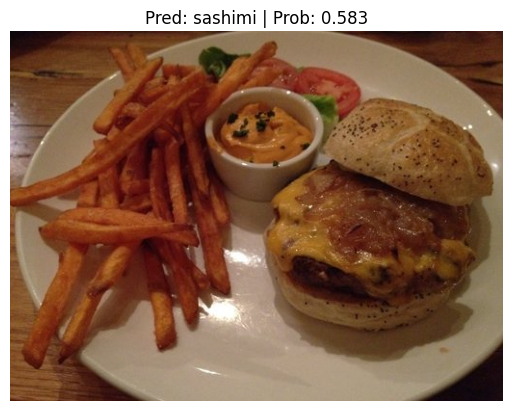

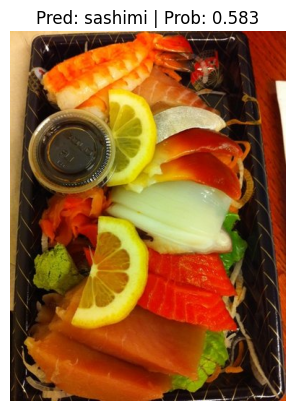

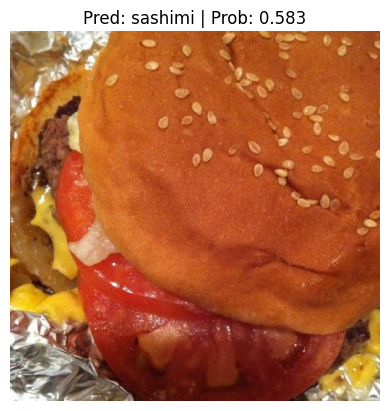

In [ ]:
import importlib
from src import predict
importlib.reload(predict)

device = "cuda" if torch.cuda.is_available() else "cpu"

import random
import os
from pathlib import Path
image_path = data_path / "food-101-mini"

image_list = list(image_path.glob("*/*.jpg"))
random_image_list = random.sample(image_list, k=3)
print(random_image_list)
for img_path in random_image_list:
  predict.predict_and_plot(model=model,
          class_names=class_names,
          image_path=str(img_path),
          image_size=(64, 64),
          transform=data_transforms,
          device=device)